In [1]:
import sys
sys.path.insert(0, '../src/')

import os
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.sparse as sp
from scipy.sparse import save_npz, load_npz, csr_matrix

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd

import utils
import graph_statistics

# Statistics

In [2]:
class Evaluation(object):
    
    def __init__(self, experiment_root, statistic_fns):
        self.experiment_root = experiment_root
        self.statistic_fns = statistic_fns    
    
    def _load_timings(self):
        return self._load('timing')
    
    def _load_overlaps(self):
        return self._load('overlap')
    
    def _load_roc_aucs(self):
        return self._load('ROC-AUC')
    
    def _load_avg_precs(self):
        return self._load('avg_prec')
    
    def _load(self, name):
        
        def get_filename(idx):
            filename = os.path.join(self.experiment_root,
                                    f'Experiment_{idx:0{self.str_exp_len}d}',
                                    'sampled_graphs',
                                    f'{name}.pickle')
            return filename
        
        dicts = [utils.load_dict(get_filename(idx)) for idx in range(self.num_experiments)]
        return dicts
    
    def compute_statistics(self):
        # parse experiment root folder
        experiment_keys = [key for key in os.listdir(self.experiment_root) if key[:11]=='Experiment_']
        self.num_experiments = len(experiment_keys)
        self.str_exp_len = len(str(self.num_experiments))
        
        # load overlaps and timings
        overlaps = self._load_overlaps()
        roc_aucs = self._load_roc_aucs()
        avg_precs = self._load_avg_precs()
        timings = self._load_timings()
        
        steps = max(timings[0].keys())
        step_len = len(str(steps))
        step_idxs = len(timings[0].keys())
        invoke_every = steps // step_idxs
        
        statistics = {name: np.zeros([self.num_experiments,
                                      step_idxs]) for name in self.statistic_fns.keys()}
        statistics['Edge Overlap (%)'] = np.zeros([self.num_experiments, step_idxs])
        statistics['ROC-AUC Score'] = np.zeros([self.num_experiments, step_idxs])
        statistics['Average Precision'] = np.zeros([self.num_experiments, step_idxs])
        statistics['Time (s)'] = np.zeros([self.num_experiments, step_idxs])
                    
        for step_idx, step in enumerate(range(invoke_every, steps+invoke_every, invoke_every)):
            for experiment in range(self.num_experiments):
                # load sparse graph
                graph_name = f'graph_{step:0{step_len}d}.npz'
                graph_path = os.path.join(self.experiment_root,
                                          f'Experiment_{experiment:0{self.str_exp_len}d}',
                                          'sampled_graphs',
                                          graph_name)
                graph = load_npz(graph_path)
                # compute statistics
                statistics['Edge Overlap (%)'][experiment, step_idx] = overlaps[experiment][step]
                statistics['ROC-AUC Score'][experiment, step_idx] = roc_aucs[experiment][step]
                statistics['Average Precision'][experiment, step_idx] = avg_precs[experiment][step]
                statistics['Time (s)'][experiment, step_idx] = timings[experiment][step]
                for name, statistic_fn in self.statistic_fns.items():
                    statistics[name][experiment, step_idx] = statistic_fn(graph)

                    
        self.statistics = statistics
        self.steps = steps
        self.invoke_every = invoke_every

    def aggregate_statistics(self, num_bins, start=0, end=1):
        # binning
        overlaps = self.statistics['Edge Overlap (%)']
        lin = np.linspace(start, end, num_bins+1)
        statistics_binned = {name:[] for name in self.statistics.keys()}
        statistics_mean = {name:np.zeros(num_bins) for name in self.statistics.keys()}
        statistics_std = {name:np.zeros(num_bins) for name in self.statistics.keys()}
        for idx, (start, end) in enumerate(zip(lin[:-1], lin[1:])):
            args = np.argwhere(np.logical_and(start<overlaps, overlaps<=end))
            for name, statistic in self.statistics.items():
                statistics_binned[name].append(statistic[args[:,0], args[:,1]])
                statistics_mean[name][idx] = statistic[args[:,0], args[:,1]].mean()
                statistics_std[name][idx] = statistic[args[:,0], args[:,1]].std()
        
        self.statistics_binned = statistics_binned
        self.statistics_mean = statistics_mean
        self.statistics_std = statistics_std
        self.mean_std = (statistics_mean, statistics_std)
                
    def export_statistics(self):
        pass
    
    def plot_statistics(self):
        pass

## Ours

In [21]:
statistic_fns = {#'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 #'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 #'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

eval_ours = Evaluation(experiment_root='../logs/CORA-ML/Ours/',
                       statistic_fns=statistic_fns)

In [22]:
eval_ours.compute_statistics()

In [23]:
eval_ours.aggregate_statistics(num_bins=10)

In [24]:
eval_ours.statistics['Edge Overlap (%)'][-1]

array([0.0048651 , 0.08978328, 0.36001769, 0.46572313, 0.55447442,
       0.62243845, 0.67787115, 0.71738169, 0.74229692, 0.77944862,
       0.79094796, 0.80790211, 0.82765738, 0.8428424 , 0.85389945,
       0.85920684, 0.87100103, 0.88146838, 0.88633348, 0.88987174])

## Forge Adjacency 

In [7]:
eval_fa = Evaluation(experiment_root='../logs/CORA-ML/baseline_FA/',
                     statistic_fns={#'Assortativity':graph_statistics.assortativity,
                                    #'Average Degree':graph_statistics.average_degree,
                                    'Claw Count':graph_statistics.claw_count,
                                    #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                                    #'Characteristic Path Length':graph_statistics.compute_cpl,
                                    #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                                    #'Gini':graph_statistics.gini,
                                    #'LCC Size':graph_statistics.LCC,
                                    #'Max Degree':graph_statistics.max_degree,
                                    #'Min Degree':graph_statistics.min_degree,
                                    #'Num Connected Components':graph_statistics.num_connected_components,
                                    #'Power Law α':graph_statistics.power_law_alpha,
                                    #'Spectral Gap':graph_statistics.spectral_gap,
                                    'Square Count':graph_statistics.square_count,
                                    #'Triangle Count':graph_statistics.triangle_count,
                                    'Wedge Count':graph_statistics.wedge_count,
                                    })

In [8]:
eval_fa.compute_statistics()

In [9]:
eval_fa.aggregate_statistics(num_bins=10)

In [10]:
eval_fa.statistics_binned

{'Claw Count': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([397830., 418238., 451536., 503754., 459385., 432744., 485779.,
         417698., 497326., 512357., 487256., 676254., 453809., 552029.,
         434527., 546974., 515068., 549012., 492104., 499961.]),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 'Square Count': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([1054., 1080., 1165., 1213., 1128., 1151., 1113.,  971., 1121.,
         1175., 1179., 1219., 1113., 1245.,  971., 1041., 1235., 1180.,
         1172., 1053.]),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 'Wedge Count': [array([], dtype=float64),
  array([], dtype=float64),
  array([], dty

In [11]:
eval_fa.mean_std

({'Claw Count': array([      nan,       nan,       nan,       nan,       nan, 489182.05,
               nan,       nan,       nan,       nan]),
  'Square Count': array([    nan,     nan,     nan,     nan,     nan, 1128.95,     nan,
             nan,     nan,     nan]),
  'Wedge Count': array([     nan,      nan,      nan,      nan,      nan, 48245.75,
              nan,      nan,      nan,      nan]),
  'Edge Overlap (%)': array([       nan,        nan,        nan,        nan,        nan,
         0.52457615,        nan,        nan,        nan,        nan]),
  'ROC-AUC Score': array([      nan,       nan,       nan,       nan,       nan, 0.5645332,
               nan,       nan,       nan,       nan]),
  'Average Precision': array([       nan,        nan,        nan,        nan,        nan,
         0.65970984,        nan,        nan,        nan,        nan]),
  'Time (s)': array([       nan,        nan,        nan,        nan,        nan,
         2.29175494,        nan,        nan,  

In [12]:
eval_fa.statistics

{'Claw Count': array([[397830.],
        [418238.],
        [451536.],
        [503754.],
        [459385.],
        [432744.],
        [485779.],
        [417698.],
        [497326.],
        [512357.],
        [487256.],
        [676254.],
        [453809.],
        [552029.],
        [434527.],
        [546974.],
        [515068.],
        [549012.],
        [492104.],
        [499961.]]), 'Square Count': array([[1054.],
        [1080.],
        [1165.],
        [1213.],
        [1128.],
        [1151.],
        [1113.],
        [ 971.],
        [1121.],
        [1175.],
        [1179.],
        [1219.],
        [1113.],
        [1245.],
        [ 971.],
        [1041.],
        [1235.],
        [1180.],
        [1172.],
        [1053.]]), 'Wedge Count': array([[47046.],
        [47144.],
        [47899.],
        [48877.],
        [48528.],
        [47275.],
        [47848.],
        [47612.],
        [48145.],
        [48386.],
        [48173.],
        [51315.],
        [47614.],

## Forge transition

In [13]:
eval_ft = Evaluation(experiment_root='../logs/CORA-ML/baseline_FT/',
                     statistic_fns={#'Assortativity':graph_statistics.assortativity,
                                    #'Average Degree':graph_statistics.average_degree,
                                    'Claw Count':graph_statistics.claw_count,
                                    #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                                    #'Characteristic Path Length':graph_statistics.compute_cpl,
                                    #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                                    #'Gini':graph_statistics.gini,
                                    #'LCC Size':graph_statistics.LCC,
                                    #'Max Degree':graph_statistics.max_degree,
                                    #'Min Degree':graph_statistics.min_degree,
                                    #'Num Connected Components':graph_statistics.num_connected_components,
                                    #'Power Law α':graph_statistics.power_law_alpha,
                                    #'Spectral Gap':graph_statistics.spectral_gap,
                                    'Square Count':graph_statistics.square_count,
                                    #'Triangle Count':graph_statistics.triangle_count,
                                    'Wedge Count':graph_statistics.wedge_count,
                                    })

In [14]:
eval_ft.compute_statistics()

In [15]:
eval_ft.aggregate_statistics(num_bins=10)

# Summary

In [ ]:
def tabular_from_statistics(EO_criterion, statistics):
    tabular_mean = {}
    tabular_std = {}
    for model_name, (statistics_mean, statistics_std) in statistics.items():
        tabular_mean[model_name] = {}
        tabular_std[model_name] = {}
        # find matching EO
        overlap = statistics_mean['Edge Overlap (%)']
        try:
            arg = np.argwhere(overlap>EO_criterion).min()
        except:
            raise Exception(f'Max Edge Overlap of {model_name} is {np.nan_to_num(overlap, -1).max():.3f}')
        for statistic_name in statistics_mean.keys():
            tabular_mean[model_name][statistic_name] = statistics_mean[statistic_name][arg]
            tabular_std[model_name][statistic_name] = statistics_std[statistic_name][arg]
    return (tabular_mean, tabular_std)

In [ ]:
tabular = tabular_from_statistics(EO_criterion=0.5,
                                  statistics={'ours': eval_ours.mean_std})

In [ ]:
tabular

In [ ]:
tabular = tabular_from_statistics(0.5, {
    'fa':eval_fa.mean_std, 
    'ft':eval_ft.mean_std,
    'ours': eval_ours.mean_std,
                                       })

In [ ]:
def df_from_tabular(tabular, keys=None):
    mean_dicts, std_dicts = tabular
    string_tabular = {}
    for (model_key, mean_dict) in mean_dicts.items():
        std_dict = std_dicts[model_key]
        string_tabular[model_key] = {}
        for (statistc_key, mean) in mean_dict.items():
            std = std_dict[statistc_key]
            string_tabular[model_key][statistc_key] = (f'{mean:.3f} \u00B1 {std:.3f}')
    df = pd.DataFrame(string_tabular.values(), string_tabular.keys())
    if keys is not None:
        df = df[keys]
    return df

In [ ]:
df = df_from_tabular(tabular)

In [ ]:
df

# True graph

In [18]:
_A_obs = load_npz('../data/CORA_ML.npz')

In [19]:
val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)

train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
assert (train_graph.toarray() == train_graph.toarray().T).all()

In [42]:
def compute_true_statistics(true_graph, statistic_fns):
    true_statistics = {}
    for statistic, fn in statistic_fns.items():
        true_statistics[statistic] = fn(true_graph)
    true_statistics['Edge Overlap (%)'] = 1
    return true_statistics

In [43]:
true_statistics = compute_true_statistics(true_graph=train_graph, statistic_fns=statistic_fns)

# BOXPLOTS

In [66]:
def boxplot(statistics_binned, true_statistics,min_binsize=3):
    # Locate bins with sufficiently many entries and remove others 
    bin_keys = [len(_bin)>=min_binsize for _bin in statistics_binned['Edge Overlap (%)']]
    statistics = {}
    for key in statistics_binned.keys():
        statistics[key] = [arr for arr, bin_key in zip(statistics_binned[key], bin_keys) if bin_key]
    # Plot at mean edge overlap for every bin
    positions = [arr.mean() for arr in statistics['Edge Overlap (%)']]
    # Make boxplot
    keys = list(statistics.keys())
    n_cols, n_rows = utils.get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 18})
    f, axs = plt.subplots(n_rows, n_cols, sharex=True, figsize=(22, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                axs[row, col].boxplot(statistics[key], positions=positions,
                                      widths=.05,
                                      showfliers=False)
                if key in true_statistics.keys():
                    axs[row, col].hlines(y=true_statistics[key],
                                         xmin=0,
                                         xmax=1,
                                         colors='green',
                                         linestyles='dashed')        
                axs[row, col].set_xlabel('Edge Overlap (%)', labelpad=5)               
                axs[row, col].set_ylabel(key, labelpad=2)
                axs[row, col].set_xticklabels([f'{EO:.2f}'[1:] for EO in positions])
            else:
                axs[row, col].axis('off')
            axs[row, col].set_xlim(0, 1)
    plt.show()   
    return

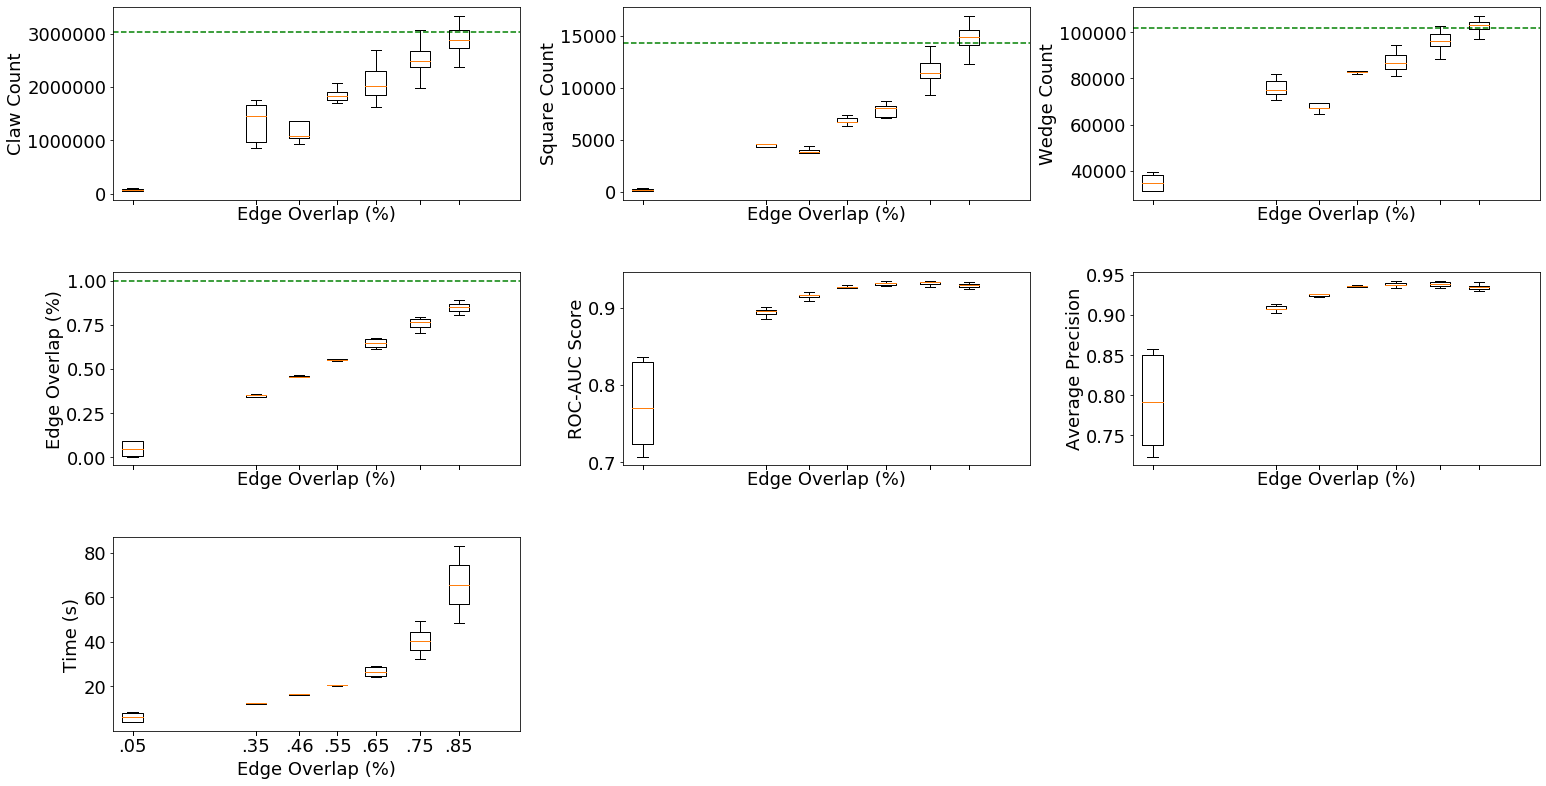

In [68]:
boxplot(statistics_binned=eval_ours.statistics_binned, true_statistics=true_statistics)